In [1]:
#from __future__ import division
%matplotlib inline
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import statistics as stat
import math
import numpy as np
from sklearn import mixture
import seaborn as sns
from haversine import haversine

In [2]:
df = pd.read_csv('./Data/Geolife-beijing_filtered.csv')

In [3]:
df['date'] = pd.to_datetime(df['date'])

In [4]:
df.head()

,dev_id,date,lat,lon,geohash,geohash_1,geohash_2,geohash_3,geohash_4,geohash_5,geohash_6
0,0,2008-10-23 02:50:00,39.984561,116.316527,386+302,193+151,129+101,97+76,77+61,39+30,19+15
1,0,2008-10-23 02:55:00,39.984456,116.306047,382+302,191+151,128+101,96+76,77+61,38+30,19+15
2,0,2008-10-23 03:00:00,39.983590,116.298869,379+302,189+151,127+101,95+76,76+61,38+30,19+15
3,0,2008-10-23 03:05:00,39.951650,116.800131,594+284,297+142,198+95,149+71,119+57,59+29,30+14
4,0,2008-10-23 03:10:00,39.951650,116.800131,594+284,297+142,198+95,149+71,119+57,59+29,30+14


In [5]:
def identify_known_places(fr, level, op):    
    
    """
    Identify the favorite locations of the individual based on her visitation frequency to the distinct locations.
    
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual.
        
    level : Float
        the visitation frequency threshold.
        
    op : Integer
        0 : to select the known places according to the MAXIMUM visitation frequency value.
        1 : to select the known places according to the AVERAGE visitation frequency value.
    
    Returns
    -------
    List of geohash
         the list of locations (geohash) knowns by the individual.
         
    """
        
    if op == 0:
        dist_freq = np.max(fr[['geohash','date']].groupby('geohash').count().date.values)
        
    elif op == 1:
        dist_freq = np.mean(fr[['geohash','date']].groupby('geohash').count().date.values)
    
    tab_visit = fr[fr.groupby('geohash')['geohash'].transform('count') >= dist_freq * level]['geohash'].unique()
        
    return tab_visit

In [6]:
########## TESTING : identify_known_places(fr, level) 
df1 = df.set_index(['dev_id'])
list_usr = df1.index
list_usr = list_usr.drop_duplicates()

k = list_usr[1]
fr = df1.loc[k]
level = 0.9
op = 0
print(identify_known_places(fr, level, op))

['441+288' '407+292' '392+309']


In [7]:
def number_of_successive_visits(fr, tab_visit):
    """
    Compute the number of successive explorations and successive returns per individual given their trajectory and set of known places.
    
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual.
        
    tab_visit : List
        the list of geohash locations knowns by the individual.
    
    Returns
    -------
    List of integers
        the table of successive explorations of the individual.
        
    List of integers
        the table of successive returns of the individual.
        
    """
   
    idx = fr.groupby('geohash').first().reset_index()
    idx['is_exp'] = idx['geohash'].transform(lambda x: True if x not in tab_visit else False)
    fr = pd.merge(fr, idx, how = 'left')
    fr = fr.fillna(value=False)
    
    l = fr.groupby(fr['is_exp'].ne(fr['is_exp'].shift()).cumsum())['is_exp'].transform('size') * np.where(fr['is_exp'], 1, -1)
    l = l.loc[l.diff() != 0] 
    
    return l[l >= 0], -l[l < 0]

In [8]:
########## TESTING : number_of_successive_visits(fr, tab_visit)
df1 = df.set_index(['dev_id'])
list_usr = df1.index
list_usr = list_usr.drop_duplicates()

k = list_usr[1]
fr = df1.loc[k]
level = 0.9
op = 0
tab_visit = identify_known_places(fr, level, op)
dist_exp, dist_ret = number_of_successive_visits(fr, tab_visit)

In [9]:
def intermittency_degreeOfReturn(fr, tab_visit):
    """
    Compute the intermittency and degree of return per individual given their trajectory.
    
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual.
    
    tab_visit : List
        the list of geohash locations knowns by the individual.
    
    Returns
    -------
    Float
        the intermittency of the individual given by: \mu = #average successive explorations + #average successive returns. 
        
    Float
        the degree of return of the individual given by: \alpha = arctng(#average successive returns/#average successive explorations).
        
    """

    dist_exp, dist_ret = number_of_successive_visits(fr, tab_visit)
    
    m_exp = np.mean(dist_exp)
    m_ret = np.mean(dist_ret)
    
    return m_exp + m_ret, math.degrees(np.arctan(m_ret / m_exp))

In [10]:
########## TESTING : intermittency_degreeOfReturn(fr, tab_visit)
inter, deg = intermittency_degreeOfReturn(fr, tab_visit)

In [11]:
def mobility_profiling(df, NB_CLUSTER, level, op):
    """
    Classify the users according to their proclivity to perform each type of visit: explorations vs. returns.
    
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual.
    
    Returns
    -------
    List of IDs
        the table of the IDs of extreme explorers or Scouters.
        
    List of IDs
        the table of the IDs of extreme explorers or Scouters.
        
    List of IDs
        the table of the IDs of extreme explorers or Scouters.
        
    """
    g0, g1, g2 = [], [], []
    tab1_x, tab2_x, tab3_x = [], [], []
    tab1_y, tab2_y, tab3_y = [], [], []

    
    g = df.groupby('dev_id').apply(lambda x: intermittency_degreeOfReturn(x[:8000], [])) #identify_known_places(x, level, op)))
    inter,deg_ret = map(np.array,zip(* g.values)) 
    min_inter, max_inter = min(inter), max(inter) 
    min_deg_ret, max_deg_ret = min(deg_ret), max(deg_ret) 
    inter = (inter - min_inter) / (max_inter -  min_inter)
    deg_ret = (deg_ret - min_deg_ret) / (max_deg_ret - min_deg_ret)
    
    
    labels = range(0, len(g)) 

    gmm = mixture.GaussianMixture(covariance_type = "full", n_components = NB_CLUSTER).fit(np.array([deg_ret, inter]).T)
    labels_nb = gmm.predict(np.array([ deg_ret, inter]).T)

    exp = min(deg_ret)
    ret = max(deg_ret)
    
    for i in range(0,len(g)):
        if deg_ret[i] == exp:
            explorers = labels_nb[i]
        elif deg_ret[i] == ret:
            returners = labels_nb[i]

    for i in range(0,len(labels_nb)):
        if labels_nb[i] == explorers:
            tab1_x.append(deg_ret[i])
            tab1_y.append(inter[i])
            g0.append(list_usr[i])

        elif labels_nb[i] == returners:
            tab2_x.append(deg_ret[i])
            tab2_y.append(inter[i])
            g1.append(list_usr[i])
            
        else:
            tab3_x.append(deg_ret[i])
            tab3_y.append(inter[i])
            g2.append(list_usr[i])
            
    
    plt.rcParams.update(plt.rcParamsDefault)        
    plt.scatter(tab1_x, tab1_y, marker = 'X', s = 150, c = '#e41a1c',label = 'Scouters')

    plt.scatter(tab2_x, tab2_y, marker = 'd', s = 150, c = '#4daf4a',label = 'Routiners')
    plt.scatter(tab3_x, tab3_y, marker = "8", s = 150, c = '#377eb8',label = 'Regulars')

    plt.xlabel("Deg of ret "+r'$\alpha$'+"=arctn(#R/#E)", fontsize = 24,fontweight = 'bold')
    plt.ylabel("Inter "+r'$\mu$'+"=#R+#E", fontsize = 24,fontweight = 'bold')
    plt.legend(prop = {'size': 22, 'weight':'bold'})

    plt.show()
    
    return g0, g1, g2

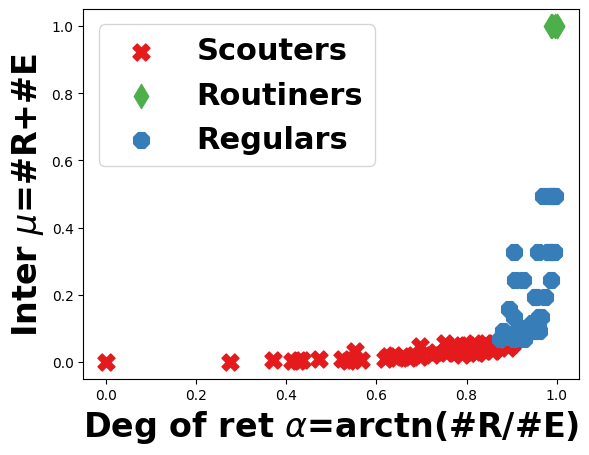

In [14]:
########## TESTING : mobility_profiling(df, NB_CLUSTER, level, op)
NB_CLUSTER = 3
level = 0.9
op = 0
g0, g1, g2 = mobility_profiling(df, NB_CLUSTER, level, op)

In [15]:
def waiting_time(fr):
    """
    Compute the waiting time per individual given their trajectory.
    
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual.
    
    Returns
    -------
    List of float
        the table of the waiting time of the individual.
        
    """
    fr = fr.loc[(fr['geohash'].shift() != fr['geohash'])]
    fr = fr.reset_index()
    fr= fr.set_index('date')
    ser_diff = fr.index.to_series().diff()
    
    return ser_diff.values.astype('timedelta64[m]').astype('float')[1:]

In [17]:
########## TESTING : waiting_time(fr)
df1 = df.set_index(['dev_id'])
list_usr = df1.index
list_usr = list_usr.drop_duplicates()

k = list_usr[5]
fr = df1.loc[k]
tab_waiting_time = waiting_time(fr)

In [18]:
def duration_of_successive_visits(fr, tab_visit):
    """
    Compute the duration of successive explorations and successive returns given the trajectory of the individual and her set of known places.
    
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual.
        
    tab_visit : List
        the list of geohash locations knowns by the individual.
    
    Returns
    -------
    List of integers
        the table of duration of successive explorations of the individual.
        
    List of integers
        the table of duration of successive returns of the individual.
        
    """
    
    idx = fr.groupby('geohash').first().reset_index()
    idx['is_exp'] = idx['geohash'].transform(lambda x: True if x not in tab_visit else False)
    fr = pd.merge(fr, idx, how = 'left')
    fr = fr.fillna(value=False)
    fr = fr.loc[(fr['is_exp'].shift() != fr['is_exp'])]
    fr = fr.reset_index()
    fr = fr.set_index(['date'])

    fr1 = pd.DataFrame(list(zip(fr.index.to_series().diff()[1:], fr['is_exp'][:-1])),columns = ['date','is_exp'])
    
    return fr1[fr1['is_exp'] == True].date.values.astype('timedelta64[m]').astype('float')[1:], fr1[fr1['is_exp'] == False].date.values.astype('timedelta64[m]').astype('float')[1:]


In [19]:
########## TESTING : duration_of_successive_visits(fr, tab_visit)

df1 = df.set_index(['dev_id'])
list_usr = df1.index
list_usr = list_usr.drop_duplicates()

k = list_usr[5]
fr = df1.loc[k]

level = 0.9
op = 0
tab_visit = identify_known_places(fr, level, op)
dur_exp, dur_ret = duration_of_successive_visits(fr, tab_visit)

In [22]:
def distance_of_successive_visits(fr, tab_visit):
    """
    Compute the distance walked when performing exploratory visits and when performing return visits.
    
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual.
        
    tab_visit : List
        the list of geohash locations knowns by the individual.
    
    Returns
    -------
    List of integers
        the table of distance walked by the individual when exploring.
        
    List of integers
        the table of distance walked by the individual when returning.
        
    """ 
    
    idx = fr.groupby('geohash').first().reset_index()
    idx['is_exp'] = idx['geohash'].transform(lambda x: True if x not in tab_visit else False)
    fr = pd.merge(fr, idx, how = 'left')
    fr = fr.fillna(value = False)
    fr = fr.loc[(fr['geohash'].shift() != fr['geohash'])]
    fr['lon2'] = fr['lon'].shift(-1)
    fr['lat2'] = fr['lat'].shift(-1)
    fr['distance'] = fr.apply(lambda x: haversine((x.lat, x.lon), (x.lat2, x.lon2)), axis = 1)
    fr.drop(['lat2', 'lon2'], axis = 1, inplace = True)
    fr1 = pd.DataFrame(list(zip(fr.groupby(fr['is_exp'].ne(fr['is_exp'].shift()).cumsum())['distance'].sum(), fr.groupby(fr['is_exp'].ne(fr['is_exp'].shift()).cumsum())['is_exp'].first())),columns =['distance','is_exp'])
    
    return fr1[fr1['is_exp']== True].distance.values, fr1[fr1['is_exp'] == False].distance.values

In [23]:
########## TESTING : distance_of_successive_visits(fr, tab_visit)

df1 = df.set_index(['dev_id'])
list_usr = df1.index
list_usr = list_usr.drop_duplicates()

k = list_usr[1]
fr = df1.loc[k]

dist_exp, dist_ret = distance_of_successive_visits(fr, [])

In [24]:
def jump_size(fr):
    """
    Compute the distance walked by the individual when transiting from one location to another.
    
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual.
    
    Returns
    -------
    List of integers
        the table of jumps in km.
        
    """
    
    fr = fr.loc[(fr['geohash'].shift() != fr['geohash'])]
    fr['lon2'] = fr['lon'].shift(-1)
    fr['lat2'] = fr['lat'].shift(-1)
    fr['distance'] = fr.apply(lambda x: haversine((x.lat, x.lon), (x.lat2, x.lon2)), axis = 1)
    fr.drop(['lat2', 'lon2'], axis = 1, inplace = True)
     
    return np.array(fr.distance)

In [25]:
########## TESTING : jump_size(fr)
df1 = df.set_index(['dev_id'])
list_usr = df1.index
list_usr = list_usr.drop_duplicates()

k = list_usr[1]
fr = df1.loc[k]

jump_size_val = jump_size(fr)

<ipython-input-24-a345ef036cfc>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fr['lon2'] = fr['lon'].shift(-1)
<ipython-input-24-a345ef036cfc>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fr['lat2'] = fr['lat'].shift(-1)
<ipython-input-24-a345ef036cfc>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/ind

In [26]:
def number_of_stops(fr):
    """
    Compute the number of distinct visited places by the individual.
    
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual.
    
    Returns
    -------
    List of integers
        the list of distinct visited geohash.
        
    """
    
    return len(np.unique(fr[['geohash']].values))

In [27]:
########## TESTING : number_of_stops(fr)
df1 = df.set_index(['dev_id'])
list_usr = df1.index
list_usr = list_usr.drop_duplicates()

k = list_usr[4]
fr = df1.loc[k]

nb_stop = number_of_stops(fr)

In [28]:
def number_of_transitions(fr):
    """
    Compute the number of transitions performed by the individual.
    
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual.
    
    Returns
    -------
    List of integers
        the number of transitions performed by the individual.
        
    """
    return len(fr['geohash'].loc[fr['geohash'].shift() != fr['geohash']])

In [29]:
########## TESTING : number_of_transitions(fr)
df1 = df.set_index(['dev_id'])
list_usr = df1.index
list_usr = list_usr.drop_duplicates()

k = list_usr[0]
fr = df1.loc[k]

nb_transitions = number_of_transitions(fr)

In [30]:
def visitation_frequency(fr):
    """
    Compute the visitation frequency of the individual to the distinct locations.
    
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual.
    
    Returns
    -------
    List of integers
        the table of visitation frequency of the individual.
        
    """

    return fr.groupby('geohash')['geohash'].count().values

In [31]:
########## TESTING : visitation_frequency(fr)
df1 = df.set_index(['dev_id'])
list_usr = df1.index
list_usr = list_usr.drop_duplicates()

k = list_usr[0]
fr = df1.loc[k]

freq_visit = visitation_frequency(fr)

In [32]:
def radius_of_gyration(fr):
    """
    Compute the radius of gyration of the individual.
    
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual.
    
    Returns
    -------
    Float
        the radius of gyration of the individual.
        
    """
    
    rg = np.sqrt(np.mean([haversine((lat, lon), (np.mean(fr.lat), np.mean(fr.lon))) ** 2.0 for lat, lon in list(zip(fr.lat, fr.lon))]))
    
    return rg

In [33]:
########## TESTING : radius_of_gyration(fr)
df1 = df.set_index(['dev_id'])
list_usr = df1.index
list_usr = list_usr.drop_duplicates()

k = list_usr[1]
fr = df1.loc[k]

rg = radius_of_gyration(fr)

In [34]:
def maximum_displacement(fr):
    """
    Compute the maximum displacement of the individual.
    
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual.
    
    Returns
    -------
    Float
        the maximum displacement of the individual.
        
    """

    lat, lon = np.mean(fr.lat), np.mean(fr.lon)
    fr['distance'] = fr.apply(lambda x: haversine((x.lat, x.lon), (lat, lon)), axis = 1)

    return np.max(fr.distance)

In [35]:
########## TESTING : maximum_displacement(fr)
df1 = df.set_index(['dev_id'])
list_usr = df1.index
list_usr = list_usr.drop_duplicates()

k = list_usr[1]
fr = df1.loc[k]

max_dis = maximum_displacement(fr)

<ipython-input-34-65aaf0dd4e6f>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fr['distance'] = fr.apply(lambda x: haversine((x.lat, x.lon), (lat, lon)), axis = 1)


In [36]:
def average_displacement(fr):
    """
    Compute the average displacement of the individual.
    
    Parameters
    ----------
    fr : DataFrame
        the trajectory of the individual.
    
    Returns
    -------
    Float
        the radius of gyration of the individual.
        
    """

    lat, lon = np.mean(fr.lat), np.mean(fr.lon)
    fr['distance'] = fr.apply(lambda x: haversine((x.lat, x.lon), (lat, lon)), axis = 1)

    return np.mean(fr.distance)

In [37]:
df1 = df.set_index(['dev_id'])
list_usr = df1.index
list_usr = list_usr.drop_duplicates()

k = list_usr[1]
fr = df1.loc[k]

mean_dis = average_displacement(fr)

<ipython-input-36-1fef43e72d0b>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fr['distance'] = fr.apply(lambda x: haversine((x.lat, x.lon), (lat, lon)), axis = 1)
